In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM,
    Dense, Dropout, Flatten
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.optimizers import Adam
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [41]:
%pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("final_balanced_training_set.csv")

# Get class counts (Assuming 'target' is the label column)
class_counts = df['attack_cat'].value_counts()
print(class_counts)

attack_cat
Generic           55468
Worms             52935
Shellcode         51270
Normal            50239
Analysis          48759
Backdoor          48329
Reconnaissance    47585
Fuzzers           46583
DoS               46520
Exploits          44882
Name: count, dtype: int64


In [10]:
from sklearn.utils import resample

# Find the minimum class count
min_count = df['attack_cat'].value_counts().min()

# Downsample all classes to match min_count
df_balanced = df.groupby('attack_cat').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Save final balanced dataset
df_balanced.to_csv("perfectly_balanced_dataset.csv", index=False)

print(df_balanced['attack_cat'].value_counts())  # Check final distribution

C:\Users\ASWATHY.I\AppData\Local\Temp\ipykernel_9828\3369417386.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('attack_cat').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


attack_cat
Analysis          44882
Backdoor          44882
DoS               44882
Exploits          44882
Fuzzers           44882
Generic           44882
Normal            44882
Reconnaissance    44882
Shellcode         44882
Worms             44882
Name: count, dtype: int64


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb

# Load the dataset
file_path = 'perfectly_balanced_dataset.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['id', 'attack_cat', 'label'])  # Drop non-feature columns
y = data['attack_cat']  # Target column (attack categories)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
label_encoders = {}  # Store encoders for later use (if needed)
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Transform column
    label_encoders[col] = le  # Store encoder for inverse transformation (optional)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



In [3]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
import xgboost as xgb

# Train an XGBoost model
xg_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=len(np.unique(y_train)),  # Number of classes in target
    eval_metric='mlogloss',
    tree_method="hist",  # Use CPU instead of GPU
    random_state=42
)

# Train the model with class weights
xg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xg_model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy score
test_acc = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53      8917
           1       0.49      0.63      0.55      9084
           2       0.40      0.55      0.46      8794
           3       0.79      0.56      0.65      8986
           4       0.88      0.89      0.89      8936
           5       1.00      0.99      0.99      8911
           6       0.97      0.90      0.94      8955
           7       0.96      0.84      0.90      8992
           8       0.96      0.99      0.97      8938
           9       0.99      1.00      0.99      9251

    accuracy                           0.78     89764
   macro avg       0.80      0.78      0.79     89764
weighted avg       0.81      0.78      0.79     89764

Test Accuracy: 0.7822


In [7]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

def tune_xgboost_params():
    # Base model
    base_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        eval_metric='mlogloss',
        tree_method="hist",
        random_state=42
    )
    
    # 1. First tune max_depth and min_child_weight
    param_test1 = {
        'max_depth': [3, 6, 9],
        'min_child_weight': [1, 4, 7]
    }
    
    random_search1 = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_test1,  # Changed from param_grid
        n_iter=5,
        scoring='accuracy',
        cv=2,
        n_jobs=-1,
        random_state=42
    )
    random_search1.fit(X_train, y_train)
    best_max_depth = random_search1.best_params_['max_depth']
    best_min_child_weight = random_search1.best_params_['min_child_weight']
    
    # 2. Tune subsample and colsample_bytree
    param_test2 = {
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8]
    }
    
    model2 = xgb.XGBClassifier(
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        eval_metric='mlogloss',
        tree_method="hist",
        random_state=42
    )
    
    random_search2 = RandomizedSearchCV(
        estimator=model2,
        param_distributions=param_test2,  # Changed from param_grid
        n_iter=4,
        scoring='accuracy',
        cv=2,
        n_jobs=-1,
        random_state=42
    )
    random_search2.fit(X_train, y_train)
    
    # 3. Tune learning_rate and n_estimators
    param_test3 = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 500]
    }
    
    model3 = xgb.XGBClassifier(
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        subsample=random_search2.best_params_['subsample'],
        colsample_bytree=random_search2.best_params_['colsample_bytree'],
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        eval_metric='mlogloss',
        tree_method="hist",
        random_state=42
    )
    
    random_search3 = RandomizedSearchCV(
        estimator=model3,
        param_distributions=param_test3,  # Changed from param_grid
        n_iter=4,
        scoring='accuracy',
        cv=2,
        n_jobs=-1,
        random_state=42
    )
    random_search3.fit(X_train, y_train)
    
    # Final model with best parameters
    final_params = {
        'max_depth': best_max_depth,
        'min_child_weight': best_min_child_weight,
        'subsample': random_search2.best_params_['subsample'],
        'colsample_bytree': random_search2.best_params_['colsample_bytree'],
        'learning_rate': random_search3.best_params_['learning_rate'],
        'n_estimators': random_search3.best_params_['n_estimators'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'tree_method': "hist",
        'random_state': 42
    }
    
    print("Best parameters:", final_params)
    return final_params

# Get best parameters and train final model
best_params = tune_xgboost_params()
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred = final_model.predict(X_test)
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {np.mean(y_pred == y_test):.4f}")


Best parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'multi:softmax', 'num_class': 10, 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'random_state': 42}

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      8917
           1       0.56      0.65      0.60      9084
           2       0.44      0.57      0.50      8794
           3       0.78      0.61      0.69      8986
           4       0.90      0.90      0.90      8936
           5       1.00      0.99      0.99      8911
           6       0.98      0.92      0.94      8955
           7       0.97      0.85      0.91      8992
           8       0.97      1.00      0.99      8938
           9       0.99      1.00      1.00      9251

    accuracy                           0.81     89764
   macro avg       0.82      0.81      0.81     89764


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define Hyperparameter Grid
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10)
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of random configurations to try
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit Model
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Hyperparameters:", random_search.best_params_)

# Train with Best Parameters
best_xg_model = random_search.best_estimator_

# Predictions
y_pred = best_xg_model.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\ASWATHY.I\anaconda3\envs\deep_learning_env\lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.99427
[1]	validation_0-mlogloss:1.79395
[2]	validation_0-mlogloss:1.64260
[3]	validation_0-mlogloss:1.52086
[4]	validation_0-mlogloss:1.41984
[5]	validation_0-mlogloss:1.33351
[6]	validation_0-mlogloss:1.25890
[7]	validation_0-mlogloss:1.19356
[8]	validation_0-mlogloss:1.13623
[9]	validation_0-mlogloss:1.08563
[10]	validation_0-mlogloss:1.04023
[11]	validation_0-mlogloss:0.99973
[12]	validation_0-mlogloss:0.96276
[13]	validation_0-mlogloss:0.92942
[14]	validation_0-mlogloss:0.89933
[15]	validation_0-mlogloss:0.87203
[16]	validation_0-mlogloss:0.84720
[17]	validation_0-mlogloss:0.82479
[18]	validation_0-mlogloss:0.80429
[19]	validation_0-mlogloss:0.78574
[20]	validation_0-mlogloss:0.76863
[21]	validation_0-mlogloss:0.75317
[22]	validation_0-mlogloss:0.73908
[23]	validation_0-mlogloss:0.72612
[24]	validation_0-mlogloss:0.71432
[25]	validation_0-mlogloss:0.70349
[26]	validation_0-mlogloss:0.69353
[27]	validation_0-mlogloss:0.68461
[28]	validation_0-mlogloss:0.6

In [10]:
best_xg_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    tree_method='hist',  # CPU-friendly
    random_state=42,
    subsample=0.9,
    n_estimators=300,
    min_child_weight=3,
    max_depth=9,
    learning_rate=0.2,
    gamma=0.2,
    colsample_bytree=0.9
)

best_xg_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = best_xg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, best_xg_model.predict(X_test)))


Test Accuracy: 0.8100129227752774
              precision    recall  f1-score   support

           0       0.60      0.59      0.59      4410
           1       0.58      0.66      0.62      4591
           2       0.45      0.58      0.51      4437
           3       0.80      0.63      0.70      4498
           4       0.90      0.90      0.90      4411
           5       1.00      0.99      0.99      4434
           6       0.97      0.92      0.94      4458
           7       0.97      0.85      0.90      4565
           8       0.97      1.00      0.99      4465
           9       0.99      1.00      1.00      4613

    accuracy                           0.81     44882
   macro avg       0.82      0.81      0.81     44882
weighted avg       0.82      0.81      0.81     44882



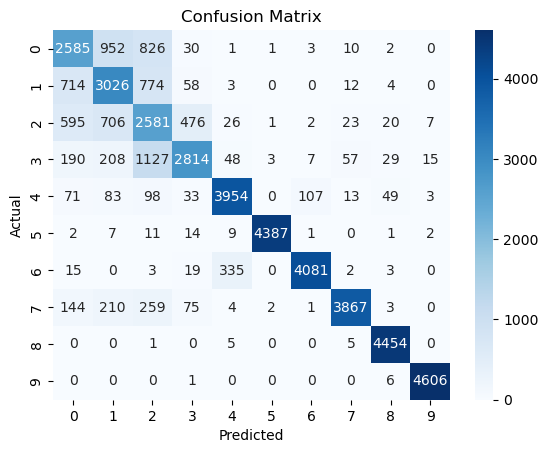

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
import joblib
joblib.dump(best_xg_model, "best_xg_model.joblib")

['best_xg_model.joblib']

In [15]:
import pandas as pd

# Get feature importances from the trained model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xg_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Select the top 8 features
top_features = feature_importances["Feature"].head(8).tolist()
print("\nSelected Top 8 Features:", top_features)



Selected Top 8 Features: ['sttl', 'service', 'ct_dst_sport_ltm', 'is_sm_ips_ports', 'swin', 'ct_flw_http_mthd', 'ct_state_ttl', 'sloss']


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])  # Use the same encoder



In [5]:
xg_model = xgb.XGBClassifier()
xg_model.fit(X_train, y_train)

importances = xg_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Drop least important features (e.g., below a threshold of 0.001)
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.001]['Feature'].tolist()
X_train = X_train.drop(columns=low_importance_features)
X_test = X_test.drop(columns=low_importance_features)


In [6]:
print(f"Original Feature Count: {X.shape[1]}")
print(f"Remaining Feature Count: {X_train.shape[1]}")
print(f"Number of Features Removed: {len(low_importance_features)}")


Original Feature Count: 42
Remaining Feature Count: 40
Number of Features Removed: 2


In [7]:
print("Removed Feature:", low_importance_features)

Removed Feature: ['is_ftp_login', 'ct_ftp_cmd']


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)


              Feature  Importance
9                sttl    0.139373
2             service    0.127388
34   ct_dst_sport_ltm    0.107889
41    is_sm_ips_ports    0.084012
19               swin    0.052392
38   ct_flw_http_mthd    0.052190
31       ct_state_ttl    0.043322
13              sloss    0.041079
28        trans_depth    0.036894
10               dttl    0.036424
27              dmean    0.031957
6              sbytes    0.024560
26              smean    0.024095
40         ct_srv_dst    0.020690
29  response_body_len    0.020556
7              dbytes    0.018286
14              dloss    0.014936
35     ct_dst_src_ltm    0.014625
3               state    0.013930
4               spkts    0.012403
1               proto    0.008526
37         ct_ftp_cmd    0.008124
33   ct_src_dport_ltm    0.006528
24             synack    0.006355
16             dinpkt    0.004849
5               dpkts    0.004765
11              sload    0.003813
12              dload    0.003657
17            

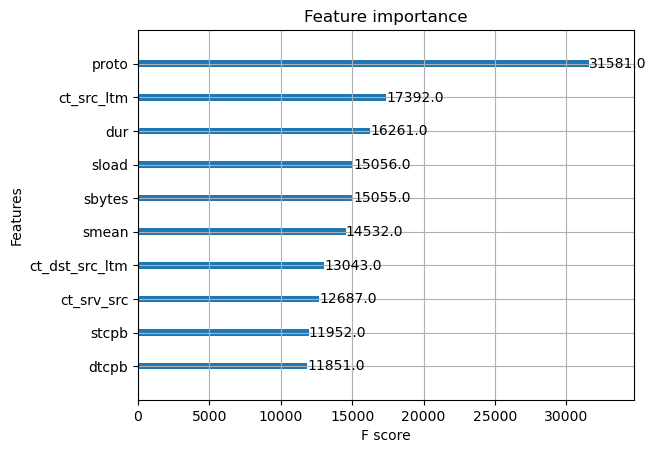

In [16]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xg_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Print the sorted feature importance list
print(feature_importances)

# Plot the feature importance again
xgb.plot_importance(best_xg_model, max_num_features=10)
plt.show()


In [62]:
print(best_xg_model.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [64]:
print(data['attack_cat'].unique())  # Replace 'label' with your actual target column name

['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
